In [1]:
#!pip install yfinance
# https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e


# .py format link :
https://github.com/tardatio/s_Predictor/tree/main/s_predictor

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import yfinance as yf
stock = yf.Ticker("BA")
stock = stock.history(period="4mo")

#Dow
dow = yf.Ticker("^DJI")
dow = dow.history(period="4mo")

#Dow_futures
mini_dow = yf.Ticker("YM=F")
mini_dow = mini_dow.history(period="4mo")

#Crude_oil
crude = yf.Ticker("CL=F")
crude = crude.history(period="4mo")

#Vix
vix = yf.Ticker("^VIX")
vix = vix.history(period="4mo")

#NYSE ARCA AIRLINE INDEX
ind = yf.Ticker("^XAL")
index = ind.history(period="4mo")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class stock_util(object):

    def __init__(self):
        pass

    def make_data(self, stock):

        # 3 days before to mean
        mu = []
        for n,i in enumerate(stock['Close']):
            if n > 1:
                mu.append((stock['Close'][n-2]+stock['Close'][n-1]+stock['Close'][n]).mean()/3)

        # Stock Price per
        stock_per = [(stock['Close'][i] - stock['Open'][i]) / stock['Close'][i] * 100 for i in range(len(stock['Open']))]

        # Stock vol %
        stock_t_vol = stock['Volume'][2:]
        stock_y_vol = stock['Volume'][1:-1]
        stock_per_vol = [(t - y) / t * 100 for t,y in zip(stock_t_vol, stock_y_vol)]


        #Today open up and close upper & vol down than yester vol  -> tomorrow down
        stock_op = stock['Open'][2:]
        stock_cl = stock['Close'][2:]

        pre1 = [op < cl and t_vol < y_vol for op, cl, t_vol, y_vol in zip(stock_op, stock_cl, stock_t_vol,stock_y_vol)]

        pre2 =[]
        pre_che = stock['Close'][2:]
        for i in range(len(stock_per_vol)):
            if stock_per_vol[i] > 0:
                pre2.append(True)

            else:
                pre2.append(False)


        # make data
        data = pd.DataFrame(data=stock['Close'][2:], index=stock.index[2:])

        data['mu'] = mu
        data["per"] = stock_per[2:]

        open_t = stock['Open'][2:]
        close_y = stock['Close'][1:-1]
        close_t = stock['Close'][2:]
        data['open_y_up'] = [t > y for t,y in zip(open_t, close_y)]

        data["open_t_up"] = stock['Open'][2:] < stock['Close'][2:]

        data["Close_y_up"] = [t > y for t,y in zip(close_t, close_y)]

        data['vol'] = stock["Volume"][2:]
        data['vol_per'] = stock_per_vol
        data['predict'] = pre1
        data['predict2'] = pre2
        data.columns = ["Close",
                        "Mu_3_days",
                        "Price_Per",
                        "Open_Y_UP",
                        "Open_T_UP",
                        "Close_Y_UP",
                        "Vol",
                        "Vol_Per",
                        "Predict_1",
                        "Predict_2"]

        return data

    def make_data_index(self, index):

        # 3 days before to mean
        mu = []
        for n,i in enumerate(index['Close']):
            if n > 1:
                mu.append((index['Close'][n-2]+index['Close'][n-1]+index['Close'][n]).mean()/3)

        # Stock Price per
        index_per = [(index['Close'][i] - index['Open'][i]) / index['Close'][i] * 100 for i in range(len(index['Open']))]

        # make data
        data = pd.DataFrame(data=index['Close'][2:], index=index.index[2:])

        data['mu'] = mu
        data["per"] = index_per[2:]

        open_t = index['Open'][2:]
        close_y = index['Close'][1:-1]
        close_t = index['Close'][2:]

        data['open_y_up'] = [t > y for t,y in zip(open_t, close_y)]
        data["open_t_up"] = index['Open'][2:] < index['Close'][2:]
        data["Close_y_up"] = [t > y for t,y in zip(close_t, close_y)]

        data.columns = ["Price end of day",
                        "Mu_3days",
                        "Price_Per",
                        "Open_Y_UP",
                        "Open_T_UP",
                        "Close_Y_UP"]

        return data

    def get_data(self, data):
        dato = np.zeros((len(data.columns), len(data)))
        for x, title in enumerate(data.columns):
            for y in range(len(dato[x])):
                dato[x][y] = data[title][y]
        return dato


    def make_bool(self, up_down):
        correct, wrong = 0, 0
        for i in up_down:
            if i == True:
                correct +=1
            else:
                wrong +=1
        return [correct, wrong]


    def make_chart_plot(self, date, predict, real, correct_d):

        predict_dato = self.make_bool(predict[:-1])
        real_dato = self.make_bool(real)

        real_dato_0 = real_dato[0]
        predict_dato_0 = predict_dato[0]

        total_up = real_dato_0


        if predict_dato_0 < real_dato_0:

            total_up +=  (real_dato_0 - predict_dato_0)

        else:
            total_up += (predict_dato_0 - real_dato_0)

        #correct_d = correct_d+2



        data = [correct_d, total_up-correct_d] # bool(0) == False

        #plot
        label = f'True: {data[0]}', f'False: {data[1]}'
        explode = (0.1, 0)
        colors = ['#99ff99','#ff9999','#66b3ff','#ffcc99']

        plt.title(f"The Percentage of Up in The Target Stock (4 months): {total_up}")
        plt.pie(data,labels=label,explode=explode, autopct='%1.1f%%', colors= colors, startangle=90)


        if int(predict[-1]) == 0:
            plt.xlabel("When the marker will close: {}, Target Stock is Down".format(date))
        else:
            plt.xlabel("When the marker will close: {}, Target Stock is Up".format(date))


        plt.legend()

        plt.show()


In [4]:
import numpy as np

class Model():
    def __init__(self, real_data, stock, dow, index, vix, mini_dow):
        self.real_data = real_data
        self.stock = stock
        self.dow = dow
        self.index = index
        self.vix = vix
        self.mini_dow = mini_dow

        # stock & dow & mini_dow
        # Close	Mu_3_days	Price_Per	Open_Y_UP	Open_T_UP	Close_Y_UP	Vol	Vol_Per	Predict_1	Predict_2

        # index & vix
        # Price end of day	Mu_3days	Price_Per	Open_Y_UP	Open_T_UP	Close_Y_UP

        #if
        self.stock_price = self.stock[0]
        self.mu = self.stock[1]
        self.stock_vol = self.stock[6]
        self.stock_vol_per = self.stock[7]

        self.vix_per= self.vix[2]
        self.index_per= self.index[2]

        # eval data
        self.stock_data = self.stock[5]

        # testing & predict data
        self.index_close_up = self.index[5]

        self.dow_open_y_up = self.dow[3]
        self.dow_pre2 = self.dow[9]

        self.stock_open_y_up = self.stock[3]
        self.stock_close_up = self.stock[5]
        self.stock_pre1 = self.stock[8]
        self.stock_pre2 = self.stock[9]

        self.vix_open_y_up = self.vix[3]
        self.vix_close_up = self.vix[5]

        self.mini_close_up = self.mini_dow[5]

        # predict data
        self.stock_open_t_up = self.stock[4]


        ####
        self.ind_t = np.zeros(len(self.real_data))
        # index 4 - > 3

        self.index_1_test = [self.stock_data, self.index_close_up, self.stock_open_y_up, self.vix_open_y_up]

        # index 18 -> 10

        self.index_2_test = [self.stock_data, self.stock_open_y_up, self.dow_open_y_up, self.stock_close_up]
        ####


        ####
        self.vol_t = np.zeros(len(self.real_data))
        # Vol T, F

        self.vol_1_set = [self.stock_data, self.stock_open_y_up,self.dow_open_y_up,
                       self.vix_open_y_up]

        # Vol 2, 11 - > 7
        """
        # 11 -> 7
        self.vol_2_set = [self.dow_open_y_up, self.vix_open_y_up, self.stock_close_up, self.stock_pre1]

        """

        #21 -> 13
        self.vol_2_set = [self.stock_data,  self.stock_open_y_up,self.dow_open_y_up,
                       self.vix_open_y_up,self.stock_close_up, self.stock_pre1]


        # Vix T,F
        self.vix_set = [self.stock_data, self.stock_open_y_up,self.dow_open_y_up,
                       self.vix_open_y_up]


        ####
        self.dum_t = np.zeros(len(self.real_data))

        # dummy1
        #self.x_test[z-2][i] == self.x_test[z-1][i] == self.x_test[z][i]== self.x_test[n+z][i] == False and (self.mu[i]-self.stock_price[i]) <=10
        self.dum_t = [self.stock_data, self.index_close_up, self.stock_open_y_up,self.dow_open_y_up,
                       self.vix_open_y_up, self.stock_pre1,self.stock_pre2]

        # dummy2
        #self.x_test[z-2][i] == self.x_test[z-1][i] == self.x_test[z][i]== self.x_test[n+z][i] == False and (self.mu[i]-self.stock_price[i]) <=10
        self.dum_tt = [self.stock_data, self.index_close_up, self.stock_open_y_up,self.dow_open_y_up,
                       self.vix_open_y_up, self.stock_pre1,self.stock_pre2]


        # Used data
        self.x_test = [self.stock_data, self.index_close_up, self.stock_open_y_up,self.dow_open_y_up,
                       self.vix_open_y_up, self.stock_pre1,self.stock_pre2,
                       ]
        """
        self.x_test = [self.stock_data, self.index_close_up, self.stock_open_y_up,self.dow_open_y_up,
                       self.vix_open_y_up,self.stock_close_up, self.stock_pre1,self.stock_pre2,
                       self.dow_pre2]
        """

        ###########testing data
        #np.insert(self.stock_data, 0, 9., axis=0)
        self.test = np.zeros(len(self.real_data)) # dummy

        self.result = np.zeros(len(self.real_data)) # training data

        self.real = np.zeros(len(self.real_data))
        self.correct = np.zeros(len(self.real_data))

        # total
        self.total = np.zeros(len(self.real_data))

    def predict_4_one(self, data, Max1_array=[], switch = False, mu_big = True, Minus1_array=[], B1_n=0, Max2_array=[], Minus2_array=[], B2_n=0):

        max1 = [Max1_array[i] > B1_n for i in range(len(Max1_array))]
        max2 = [Max2_array[i] > B2_n for i in range(len(Max2_array))]

        minus1 = [Minus1_array[i] < B1_n for i in range(len(Minus1_array))]
        minus2 = [Minus2_array[i] < B2_n for i in range(len(Minus2_array))]


        z = 2
        count = 0
        while len(data) > z:
            for n in reversed(range(len(data[:z-1:-1]))):
                for i in range(len(data)):
                    if mu_big:
                        if switch == False:
                            if self.stock_price[i] < self.mu[i]:
                                if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                    self.result[i] += 1
                        else:

                            if len(max1):
                                if len(max2):
                                    if self.stock_price[i] < self.mu[i] and max1[i] == True and max2[i] == True:
                                            if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                                self.result[i] += 1
                                elif len(minus1):
                                    if self.stock_price[i] < self.mu[i] and max1[i] == True and minus1[i] == True:
                                        if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                                self.result[i] += 1
                                else:
                                    if self.stock_price[i] < self.mu[i] and max1[i] == True:
                                        if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                            self.result[i] += 1


                            elif len(minus1):

                                if len(minus2):
                                    if self.stock_price[i] < self.mu[i] and minus1[i] == True and minus2[i] == True:
                                            if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                                self.result[i] += 1
                                elif len(max1):
                                    if self.stock_price[i] < self.mu[i] and minus1[i] == True and max1[i] == True:
                                            if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                                self.result[i] += 1
                                else:
                                    if self.stock_price[i] < self.mu[i] and minus1[i] == True:
                                        if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                            self.result[i] += 1
                    else:
                        if switch == False:
                            if self.stock_price[i] > self.mu[i]:
                                if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                    self.result[i] += 1
                        else:

                            if len(max1):
                                if len(max2):
                                    if self.stock_price[i] > self.mu[i] and max1[i] == True and max2[i] == True:
                                            if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                                self.result[i] += 1
                                elif len(minus1):
                                    if self.stock_price[i] > self.mu[i] and max1[i] == True and minus1[i] == True:
                                        if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                                self.result[i] += 1
                                else:
                                    if self.stock_price[i] > self.mu[i] and max1[i] == True:
                                        if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                            self.result[i] += 1


                            elif len(minus1):

                                if len(minus2):
                                    if self.stock_price[i] > self.mu[i] and minus1[i] == True and minus2[i] == True:
                                            if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                                self.result[i] += 1
                                elif len(max1):
                                    if self.stock_price[i] > self.mu[i] and minus1[i] == True and max1[i] == True:
                                            if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                                self.result[i] += 1
                                else:
                                    if self.stock_price[i] > self.mu[i] and minus1[i] == True:
                                        if data[z-2][i] == data[z-1][i] == data[z][i]== data[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                                            self.result[i] += 1

            z += 1
        return self.result

    def evaluate(self,real_eval_, n):
        #real_eval_ = np.zeros(len(com))
        for i in range(len(real_eval_)):
            if real_eval_[i] != 0:
                if real_eval_[i] >= n-1:
                    self.ind_t[i] = 1
                else:
                    self.ind_t[i] = 0

        return self.ind_t


    def train_predict(self):
        dummy_t = np.zeros(len(self.real_data))
        dummy_1 = np.zeros(len(self.real_data))
        dummy_2 = np.zeros(len(self.real_data))

        ## from 3 not self
        dummy_3 = np.zeros(len(self.real_data))
        dummy_4 = np.zeros(len(self.real_data))

        #predict_4_one(self, data, Max1_array=[],Minus1_array, B1_n=0, B1 = False, Max2_array=[], Minus2_array, B2_n=0, B2 = False)
        #max1 = [Max1_array[i] > B1_n for i in range(len(Max1_array))]
        #max2 = [Max2_array[i] > B2_n for i in range(len(Max2_array))]

        #minus1 = [Minus1_array[i] < B_n for i in range(len(Minus1_array))]
        #minus2 = [Minus2_array[i] < B2_n for i in range(len(Minus2_array))]

        # air index
        dummy_1 += self.predict_4_one(self.index_2_test, switch = True, Minus1_array=self.index_per, B1_n=-4)
        dummy_1 += self.predict_4_one(self.index_1_test, switch = True, Minus1_array=self.stock_vol, B1_n=0, Max2_array=self.index_per, B2_n=0)

        dummy_1 += self.result

        self.ind_t = self.evaluate(dummy_1, 3)
        dummy_t  += self.ind_t


        # vol_1
        dummy_2 += self.predict_4_one(self.vol_1_set, switch = True, Max1_array=self.stock_vol, B1_n=0)
        # vol_2
        #dummy_2 += self.predict_4_one(self.vol_2_set, switch = True, Max1_array=self.stock_vol, B1_n=0)

        # 4 in one
        # vol_1

        """
        z = 2
        while len(self.vol_1_set) > z:
            for n in reversed(range(len(self.vol_1_set[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] > self.mu[i] and self.stock_vol[i] < 0:
                        if self.vol_1_set[z-2][i] == self.vol_1_set[z-1][i] == self.vol_1_set[z][i]== self.vol_1_set[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                            self.result[i] = 1
            z += 1
        dummy_2 += self.result
        """



         # 4 in one

        z = 2
        while len(self.vol_2_set) > z:
            for n in reversed(range(len(self.vol_2_set[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] > self.mu[i] and self.stock_vol[i] > 0:
                        if self.vol_2_set[z-2][i] == self.vol_2_set[z-1][i] == self.vol_2_set[z][i]== self.vol_2_set[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                            self.result[i] = 1
            z += 1
        dummy_2 += self.result


        # vix
        z = 2
        while len(self.vix_set) > z:
            for n in reversed(range(len(self.vix_set[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] > self.mu[i] and self.vix_per[i] >-4:
                        if self.vix_set[z-2][i] == self.vix_set[z-1][i] == self.vix_set[z][i]== self.vix_set[n+z][i] == True and (self.mu[i]-self.stock_price[i]) <=10:

                            self.result[i] = 1

            z += 1
        dummy_2 += self.result
        self.vol_t = self.evaluate(dummy_2, 3)
        dummy_t  += self.vol_t



        ################################################
        ### dummy


        z = 2
        while len(self.dum_t) > z:
            for n in reversed(range(len(self.dum_t[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] < self.mu[i]:
                        if self.dum_t[z-2][i] == self.dum_t[z-1][i] == self.dum_t[z][i]== self.dum_t[n+z][i] == False and (self.mu[i]-self.stock_price[i]) <=10:

                            self.result[i] = 1

            z += 1
        dummy_3 += self.result


        ### dummy2


        z = 2
        while len(self.dum_tt) > z:
            for n in reversed(range(len(self.dum_tt[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] > self.mu[i]:
                        if self.dum_tt[z-2][i] == self.dum_tt[z-1][i] == self.dum_tt[z][i]== self.dum_tt[n+z][i] == False and (self.mu[i]-self.stock_price[i]) <=10:

                            self.result[i] = 1

            z += 1

        dummy_3 += self.result

        ### dummy3


        z = 2
        while len(self.x_test) > z:
            for n in reversed(range(len(self.x_test[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] < self.mu[i]:
                        if self.x_test[z-2][i] == self.x_test[z-1][i] == self.x_test[z][i]== self.x_test[n+z][i] == False and (self.mu[i]-self.stock_price[i]) <=5:

                            self.result[i] = 1

            z += 1

        dummy_3 += self.result


        ################################################


        #######################################################################
        ### dummy


        z = 2
        while len(self.dum_t) > z:
            for n in reversed(range(len(self.dum_t[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] < self.mu[i]:
                        if self.dum_t[z-2][i] == self.dum_t[z-1][i] == self.dum_t[z][i]== self.dum_t[n+z][i] == False:

                            self.result[i] = 1

            z += 1
        dummy_4 += self.result


        ### dummy2


        z = 2
        while len(self.dum_tt) > z:
            for n in reversed(range(len(self.dum_tt[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] > self.mu[i]:
                        if self.dum_tt[z-2][i] == self.dum_tt[z-1][i] == self.dum_tt[z][i]== self.dum_tt[n+z][i] == False:

                            self.result[i] = 1
            z += 1

        dummy_4 += self.result

        ### dummy3

        # 4 in one

        z = 2
        while len(self.x_test) > z:
            for n in reversed(range(len(self.x_test[:z-1:-1]))):
                for i in range(len(self.real_data)):
                    if self.stock_price[i] > self.mu[i]:
                        if self.x_test[z-2][i] == self.x_test[z-1][i] == self.x_test[z][i]== self.x_test[n+z][i] == False:

                            self.result[i] = 1
            z += 1

        dummy_4 += self.result


        ################################################


        for i in range(len(dummy_t)):
            if dummy_t[i] != 0:
                self.total[i] += 1



        ##dummy_3 +
        for i in range(len(dummy_3)):
            if dummy_3[i] == 2 and self.total[i] != dummy_3[i]:
                self.total[i] += 1
            if dummy_3[i] == 0 and self.total[i] != dummy_3[i]:
                self.total[i] = 0

        ##dummy_4 --
        for i in range(len(dummy_4)):

            if dummy_4[i] == 1 and self.total[i] != dummy_4[i]:
                self.total[i] +=1

        #### important!! adding one zero from the begining
        self.result = np.insert(self.result, 0, 0., axis=0)
        self.total = np.insert(self.total, 0, 0., axis=0)



        # to get c
        c, w = 0, 0
        for i in range(len(self.total)-1):

            if self.total[i] == self.real_data[i] and self.total[i]==True:
                c += 1

        #self.total = np.insert(self.total, -1, 5., axis=0)
        return self.result, c, self.total


In [5]:
util = stock_util()

make_stock = util.make_data(stock)
make_dow = util.make_data(dow)
make_mini_dow = util.make_data(mini_dow)
make_crude = util.make_data(crude)
make_vix = util.make_data_index(vix)
make_index = util.make_data_index(index)


stock_ = util.get_data(make_stock)
dow_ = util.get_data(make_dow)
mini_dow_ = util.get_data(make_mini_dow)
crude_ = util.get_data(make_crude)
vix_ = util.get_data(make_vix)
index_ = util.get_data(make_index)

In [23]:
val = [stock['Close'][i] > stock['Open'][i] for i in range(len(stock))]

real_data = np.zeros(len(val)-1)
for i in range(len(real_data)):
    if val[i] == True:
        real_data[i] = 1
real_data = real_data[1:]

In [24]:
model = Model(real_data, stock_, dow_, index_, vix_, mini_dow_)

In [25]:
_, correct_d, predict_data_t  = model.train_predict()

In [26]:
correct_d

24

In [27]:
predict_data_t

array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])

In [28]:
real_data # real_data

array([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.])

In [19]:
util = stock_util()

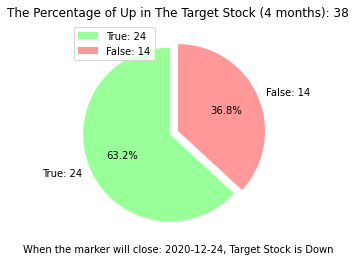

In [29]:
util.make_chart_plot(stock.index[-1].date(), predict_data_t, real_data, correct_d)